In [596]:
import numpy as np
from utils import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [597]:
X_train, Y_train = read_csv('data/train-big.csv') 
X_test, Y_test = read_csv('data/test_minus_dev_big.csv') 
# small 
X_dev, Y_dev = read_csv('data/dev_big.csv')


ratio=0.1
total_train_num=len(X_train)
train_num = int(ratio * total_train_num)
train_index=(np.random.random([train_num])*total_train_num).astype(int)
print (train_num)

X_train=X_train[train_index]
Y_train = Y_train[train_index]


maxLen = len(max(X_train, key=len).split())+10
print(maxLen)

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            if w not in word_to_index:
                X_indices[i, j] = 0 # HACK - FIX SOON
            else:
                if j >= maxLen:
                    print (sentence_words)
                X_indices[i, j] = word_to_index[w]
            j = j+1
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["lemon"].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim)) # curious why not transpose of this...
    # Sets each row "index" of the embedding matrix to be 
    # the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix]) # now it's pretrained!

    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
X_dev_indices = sentences_to_indices(X_dev, word_to_index, maxLen)

9908
33


In [598]:
def Model_V1(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Model-V1 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape = input_shape, dtype = np.int32)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagates sentence_indices through the embedding layer
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    LSTM1 = LSTM(128, return_sequences = True,name='LSTM1')(embeddings)
    # Adds dropout with probability 0.5
    X = Dropout(0.5)(LSTM1)
    # Another LSTM layer, but just returns one output
    LSTM2 = LSTM(128, return_sequences = True, name='LSTM2')(X)
    
    def get_last(X):
        return X[:,-1,:]
    
    LSTM2Last = Lambda(get_last, name='LSTM2-last')(LSTM2)
    Dropout2 = Dropout(0.5,name='Dropout2')(LSTM2Last)
    
    # Propagating through a Dense layer with sigmoid activation to get back a scalar
    Dense1 = Dense(1,name='Dense1')(Dropout2)
    X = Activation('sigmoid',name='output_layer')(Dense1)

    model = Model(inputs = sentence_indices, outputs = X)

    return model

# Adjustable model

In [599]:
def Model_V2(input_shape, word_to_vec_map, word_to_index,num_layer,num_cell,dropout_ratio,bidirectional):
    """
    Function creating the Model-V1 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape = input_shape, dtype = np.int32)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagates sentence_indices through the embedding layer
    X = embedding_layer(sentence_indices)
    
    # add the first layer, if there is any.
    if num_layer == 2:
        print (2)
        # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
        if bidirectional == True:
            print ('b1')
            LSTM1 = Bidirectional(LSTM(num_cell, return_sequences = True),name='LSTM1')(X)
        else:
            print('l1')
            LSTM1 = LSTM(num_cell, return_sequences = True,name='LSTM1')(X)
        # Adds dropout with probability 0.5
        X = Dropout(dropout_ratio)(LSTM1)

    # add second layer (or the only layer)
    if  num_layer == 1 and bidirectional == True:
        print ('b2')
        LSTM2 = Bidirectional(LSTM(num_cell, return_sequences = True), name='LSTM2')(X)
    else:
        print ('l2')
    # Another LSTM layer, but just returns one output
        LSTM2 = LSTM(num_cell, return_sequences = True, name='LSTM2')(X)
    
    def get_last(X):
        return X[:,-1,:]
    
    LSTM2Last = Lambda(get_last, name='LSTM2-last')(LSTM2)
    Dropout2 = Dropout(dropout_ratio,name='Dropout2')(LSTM2Last)
    
    # Propagating through a Dense layer with sigmoid activation to get back a scalar
    Dense1 = Dense(1,name='Dense1')(Dropout2)
    X = Activation('sigmoid',name='output_layer')(Dense1)

    model = Model(inputs = sentence_indices, outputs = X)

    return model

# Training the model

In [600]:
#model
num_layer=[1] # index 0 is better
num_cell=[64] # 0 index
drop_ratio=[0.3] # 2 index
bidirectional=[False] # 0 index

# optimizer
beta1=0.9
beta2=0.999

#fitting
learning_rate=[0.001]#[0.001,0.002,0.003,0.004]
batch_size=[300]#[5,10,15,20,25]

In [601]:
il=0
ic=0
idr=0
ibr=0
# might want to change the metric here
model = Model_V2((maxLen,), word_to_vec_map, word_to_index,num_layer[il],num_cell[ic],drop_ratio[idr],bidirectional[ibr])
optimizer = Adam(lr=learning_rate[ilr], beta_1=beta1, beta_2=beta2, decay=0.0, epsilon=None)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# train the model
model_fitting = model.fit(X_train_indices, Y_train, epochs = 20, batch_size = batch_size[ibs], shuffle=True,validation_data=(X_dev_indices, Y_dev))
loss, acc = model.evaluate(X_test_indices, Y_test)
model.save('word_model_PB.h5')
print("Test accuracy = ", acc)
val_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['val_acc'][-1]
tra_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['acc'][-1]

l2
Train on 9908 samples, validate on 184 samples
Epoch 1/20
9908/9908 [==============================] - 15s 1ms/step - loss: 0.6911 - acc: 0.5230 - val_loss: 0.7353 - val_acc: 0.3424
Epoch 2/20
9908/9908 [==============================] - 2s 181us/step - loss: 0.6647 - acc: 0.5897 - val_loss: 0.6621 - val_acc: 0.6576
Epoch 3/20
9908/9908 [==============================] - 2s 178us/step - loss: 0.6171 - acc: 0.6509 - val_loss: 0.5773 - val_acc: 0.7120
Epoch 4/20
9908/9908 [==============================] - 2s 181us/step - loss: 0.5846 - acc: 0.6900 - val_loss: 0.6051 - val_acc: 0.6848
Epoch 5/20
9908/9908 [==============================] - 2s 181us/step - loss: 0.6154 - acc: 0.6655 - val_loss: 0.4851 - val_acc: 0.7609
Epoch 6/20
9908/9908 [==============================] - 2s 179us/step - loss: 0.5414 - acc: 0.7302 - val_loss: 0.4702 - val_acc: 0.7500
Epoch 7/20
9908/9908 [==============================] - 2s 179us/step - loss: 0.5202 - acc: 0.7445 - val_loss: 0.5179 - val_acc: 0.7337

In [602]:
[0.8414 ,0.9076]

[0.8414, 0.9076]

# Hyper parameter Tuning

In [ ]:
for il in range(len(num_layer)):
    for ic in range(len(num_cell)):
        for idr in range(len(drop_ratio)):
            for ibr in range(len(bidirectional)):
                for ilr in range(len(learning_rate)):
                    for ibs in range(len(batch_size)):
                        print ('num_layer:'+str(num_layer[il]),'num_cell:'+str(num_cell[ic]),'drop_ratio:'+str(drop_ratio[idr]),'bidirectional:'+str(bidirectional[ibr]))
                        print('val_acc'+str(val_acc[il][ic][idr][ibr][ilr][ibs]),'tra_acc'+str(tra_acc[il][ic][idr][ibr][ilr][ibs]))

In [ ]:
val_acc=np.zeros([len(num_layer),len(num_cell),len(drop_ratio),len(bidirectional),len(learning_rate),len(batch_size)])
tra_acc=np.zeros([len(num_layer),len(num_cell),len(drop_ratio),len(bidirectional),len(learning_rate),len(batch_size)])
for il in range(len(num_layer)):
    for ic in range(len(num_cell)):
        for idr in range(len(drop_ratio)):
            for ibr in range(len(bidirectional)):
                for ilr in range(len(learning_rate)):
                    for ibs in range(len(batch_size)):
                        # might want to change the metric here
                        model = Model_V2((maxLen,), word_to_vec_map, word_to_index,num_layer[il],num_cell[ic],drop_ratio[idr],bidirectional[ibr])
                        optimizer = Adam(lr=learning_rate[ilr], beta_1=beta1, beta_2=beta2, decay=0.0, epsilon=None)
                        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                        # train the model
                        model_fitting = model.fit(X_train_indices, Y_train, epochs = 20, batch_size = batch_size[ibs], shuffle=True,validation_data=(X_dev_indices, Y_dev))
                        loss, acc = model.evaluate(X_test_indices, Y_test)
                        model.save('my_model.h5')
                        print("Test accuracy = ", acc)
                        val_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['val_acc'][-1]
                        tra_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['acc'][-1]
                    

In [ ]:
print(val_acc.shape)
np.mean(val_acc[:,:,:,:,:,:,:])

# Weight Plot

In [603]:
model_fitting.history['val_acc'][-1]
model_fitting.history['acc'][-1]

0.8572870396200957

In [604]:
from __future__ import print_function

from keras import backend as K
from keras.engine import Input, Model, InputSpec
from keras.layers import Dense, Activation, Dropout, Lambda
from keras.layers import Embedding, LSTM
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils.data_utils import get_file
from keras.datasets import imdb
from keras.models import load_model


import numpy as np
import random
import sys
import pdb

In [605]:
# Loading the model
from keras.models import load_model
model = load_model('word_1lay_64cell_30drop_1dir_60ep_50kex.h5')

In [607]:
def visualize_model_bs(model, include_gradients=False):

    LSTM2 = model.get_layer('LSTM2')
    Dropout2 = model.get_layer('Dropout2')
    output_layer = model.get_layer('output_layer')

    inputs = []
    inputs.extend(model.inputs)

    outputs = []
    outputs.extend(model.outputs)
    outputs.append(LSTM2.output)
    outputs.append(LSTM2.cell.kernel_f)  # -- weights of the forget gates (assuming LSTM)
    #print (LSTM1.trainable_weights)

    if include_gradients:
        loss = K.mean(model.output)  # [batch_size, 1] -> scalar
        grads = K.gradients(loss, LSTM2.output)
        grads_norm = grads / (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        outputs.append(grads_norm)

    all_function = K.function(inputs, outputs)
    output_function = K.function([Dropout2.input], model.outputs)
    print(Dropout2.input)
    return all_function, output_function

In [608]:
# Not yet working...
import tensorflow as tf

def getWeightedOutputs(model):

    LSTM2 = model.get_layer('LSTM2')
    Dense1 = model.get_layer('Dense1')
    
    weights = tf.convert_to_tensor(Dense1.get_weights()[0], dtype=np.float32)
    weights = tf.reshape(weights,(1,1,64))
    print(weights)
    print(LSTM2.output)

    weightedOutputs = tf.multiply(LSTM2.output, weights)
    return K.function([model.inputs], [weightedOutputs])

X = sentences_to_indices(t, word_to_index, maxLen)
get_weights = getWeightedOutputs(model)
rnn_values_weighted = get_weights([X])

Tensor("Reshape:0", shape=(1, 1, 64), dtype=float32)
Tensor("LSTM2_74/transpose_1:0", shape=(?, ?, 64), dtype=float32)


TypeError: unhashable type: 'list'

In [ ]:
model=load_model('word_1lay_64cell_30drop_1dir_60ep_50kex.h5')
all_function, output_function = visualize_model_bs(model, include_gradients=True)

In [70]:
maxLen=33
sentence="clock picking a way him to"
t = np.array([sentence])
X = sentences_to_indices(t, word_to_index, maxLen)
# -- Return scores, raw rnn values and gradients
# scores is equivalent to model.predict(X)
scores, rnn_values, rnn_gradients, W_i = all_function([X])
print(scores.shape, rnn_values.shape, rnn_gradients.shape, W_i.shape)

# -- score prediction
print("Scores:", scores)

# -- Return scores at each step in the time sequence
time_distributed_scores = map(lambda x: output_function([x]), rnn_values)
print("Time distributed (word-level) scores:", map(lambda x: x[0], time_distributed_scores))


(1, 1) (1, 33, 64) (50, 64) (1, 1, 33, 64)
Scores: [[0.00015642]]
Time distributed (word-level) scores: [array([[5.5311471e-01],
       [7.5159383e-01],
       [7.9312688e-01],
       [6.4650297e-01],
       [6.0913348e-01],
       [4.6933240e-01],
       [5.6290430e-01],
       [6.3932526e-01],
       [7.3224401e-01],
       [8.1640381e-01],
       [8.8241988e-01],
       [9.2631572e-01],
       [9.5257306e-01],
       [9.6745300e-01],
       [9.7554922e-01],
       [9.7955281e-01],
       [9.8074728e-01],
       [9.7934705e-01],
       [9.7429252e-01],
       [9.6170306e-01],
       [9.2857486e-01],
       [8.2825148e-01],
       [5.3971142e-01],
       [1.5634350e-01],
       [2.2301400e-02],
       [3.2153302e-03],
       [7.9706294e-04],
       [3.5778593e-04],
       [2.2610926e-04],
       [1.7009153e-04],
       [1.4622005e-04],
       [1.4235283e-04],
       [1.5641832e-04]], dtype=float32)]


In [71]:
print(maxLen)

33


In [72]:
# choose the color index
from colored import fg, bg, attr
min_c=0
max_c=255
for i in range(min_c,max_c):
    print ('%s%s' % (bg (i),str(i)),end="")
    
print('\n------Color index:-----')

color_index=[196,197,198,205,212,219,225,231,229,193,192,191,155,154,82]
for i in color_index:
    print ('%s%s' % (bg (i),str(i)),end="")

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254
------Color index:-----
19619719820521221922523122919319219115515482

In [90]:
from colored import fg, bg, attr
words=sentence.split()

rnn_shape=[1, maxLen, 64]
color_index=[196,197,198,205,212,219,225,231,229,193,192,191,155,154,82]
len_color=len(color_index)
color_weight=np.array(rnn_values)
color_weight_range=(max(color_weight.flatten())-min(color_weight.flatten()))+1 # +1 make it safer, and not over the range
color_weight=len_color*(color_weight-min(color_weight.flatten()))/color_weight_range
color_weight=color_weight.reshape(rnn_shape)


# color tuning
min_c=int(min(color_weight.flatten()))
max_c=int(max(color_weight.flatten()))
print(min_c,max_c)

    
print("")

def clamp(x, minval, maxval):
    return max(minval, min(x, maxval))


for i in range(rnn_shape[2]):
    #for w in range(rnn_shape[2]):
    print ('%s%s: ' % (bg (231),'Neuron '+str(i)), end="")
    for w in range(len(words)):
        idx = clamp(int(color_weight[0,w,i]), 0, len(color_index)-1)
        print ('%s%s' % (bg (color_index[idx]),words[w]),end="")
        print (' ' ,end="")
    print ("")


0 9

Neuron 0: clock picking a way him to 
Neuron 1: clock picking a way him to 
Neuron 2: clock picking a way him to 
Neuron 3: clock picking a way him to 
Neuron 4: clock picking a way him to 
Neuron 5: clock picking a way him to 
Neuron 6: clock picking a way him to 
Neuron 7: clock picking a way him to 
Neuron 8: clock picking a way him to 
Neuron 9: clock picking a way him to 
Neuron 10: clock picking a way him to 
Neuron 11: clock picking a way him to 
Neuron 12: clock picking a way him to 
Neuron 13: clock picking a way him to 
Neuron 14: clock picking a way him to 
Neuron 15: clock picking a way him to 
Neuron 16: clock picking a way him to 
Neuron 17: clock picking a way him to 
Neuron 18: clock picking a way him to 
Neuron 19: clock picking a way him to 
Neuron 20: clock picking a way him to 
Neuron 21: clock picking a way him to 
Neuron 22: clock picking a way him to 
Neuron 23: clock picking a way him to 
Neuron 24: clock picking a way him to 
Neuron 25: clock picking a way

In [74]:
rnn_shape[2]

64

In [91]:
from colored import fg, bg, attr

words=sentence.split()
color_weight=np.array(time_distributed_scores).reshape(maxLen)
color_weight_range=max(color_weight)-min(color_weight)+1
color_weight=len_color*(color_weight-min(color_weight.flatten()))/color_weight_range

print (color_weight)
for i in range(len(words)):
    print ('%s%s' % (bg (color_index[int(color_weight[i])]),words[i]),end="")
    print ('%s '%attr(1) ,end="")    

[4.1879048e+00 5.6910758e+00 6.0056238e+00 4.8951759e+00 4.6121602e+00
 3.5533843e+00 4.2620459e+00 4.8408160e+00 5.5445313e+00 6.1819105e+00
 6.6818795e+00 7.0143223e+00 7.2131805e+00 7.3258729e+00 7.3871894e+00
 7.4175105e+00 7.4265566e+00 7.4159517e+00 7.3776722e+00 7.2823257e+00
 7.0314317e+00 6.2716384e+00 4.0863962e+00 1.1829807e+00 1.6782030e-01
 2.3273021e-02 4.9584103e-03 1.6315705e-03 6.3432462e-04 2.1007750e-04
 2.9288136e-05 0.0000000e+00 1.0652419e-04]
clock picking a way him to 

In [96]:
maxLen=33


# -- Return scores, raw rnn values and gradients
# scores is equivalent to model.predict(X)
scores, rnn_values, rnn_gradients, W_i = all_function([X_train_indices])
print(scores.shape, rnn_values.shape, rnn_gradients.shape, W_i.shape)

maxes = tf.Session().run(tf.argmax(rnn_values, axis=0))
print(maxes)

# -- Return scores at each step in the time sequence
# time_distributed_scores = map(lambda x: output_function([x]), rnn_values)
# print("Time distributed (word-level) scores:", map(lambda x: x[0], time_distributed_scores))

(9908, 1) (9908, 35, 64) (50, 64) (1, 9908, 35, 64)
[[1746  169 2032 ... 9738  432 8956]
 [1115  665 8865 ... 2186 3956 1668]
 [8274 1403 3507 ... 4006   96  426]
 ...
 [8837 2971 2266 ... 6348 4645 1714]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [114]:
lastSlice = rnn_values[:,-3,:] # all zeroes if it's -2 etc
lastMaxes = tf.Session().run(tf.argmax(lastSlice, axis=0))
print(lastMaxes)

[8837 2971 2266  920 1942 2503 7300 5181  436 7696 5313 4328 5896 4645
 3716 3920 8956 7124 4690 9465 3563 2909 5181 4758  573 4313 4690 1942
 4328 3263 7699 4758  573 4601 4153 4690 5415 4082 5899 2909 5687 1714
 2114 6577  170 4690 7746  608 7309 9507 1995 9536   96 5555 6577 7699
 3263 5181 4153 4548 4314 6348 4645 1714]


In [115]:
X_train[lastMaxes]

array(['In the past I used to vote the Democratic ticket', 'in The I the',
       "They say fine words are no virtue if they're insincere and that's him in a nutshell He's all talk but doesn't mean a word of it",
       'No',
       '26511\tfra\tAimes-tu les serpents\xe2\x80\xaf Bien s\xc3\xbbr que non',
       'this hours the', 'down is taken trees eggs with they',
       "The information presented in Kelly's paper on color coordination is seen to be of use in building up an alternative theory",
       "soccer Some doubtful people children don't reminds be at ish wish",
       'star weight prove will before business to a excellent out trumpet',
       'almost past people good property may too teacher dress make a',
       'One of the reasons is the difference between Japan and other countries in their attitudes toward education',
       "day This a read the in hear her hiked I'm payment latest",
       'We accept making a reduction in price of 5% if this will help you to develop a new

# Data processing dev/test/train

In [494]:
# small 
X_test, Y_test = read_csv('data/test.csv') 

In [495]:
# small
import pandas as pd
dev_ratio=0.1
total_test_num=len(X_test_indices)
dev_num = int(dev_ratio * len(X_test_indices))
X_dev_indices = []
print (dev_num)
dev_index=(np.random.random([dev_num])*total_test_num).astype(int)

X_dev_indices=X_test_indices[dev_index,:]
X_dev = X_test[dev_index]
Y_dev = Y_test[dev_index]

X_test_after_dev=np.delete(X_test,dev_index,0)
Y_test_after_dev=np.delete(Y_test,dev_index,0)

# test after dev
test_after_dev={'X': X_test_after_dev, 'Y': Y_test_after_dev}
test_after_dev = pd.DataFrame(test_after_dev)
test_after_dev.to_csv('test_minus_dev.csv',header=False,index=False)

# dev
dev={'X': X_dev, 'Y': Y_dev}
dev = pd.DataFrame(dev)
dev.to_csv('dev.csv',header=False,index=False)

166


In [496]:
# big
X_test, Y_test = read_csv('data/test-big.csv')

# small
import pandas as pd
dev_ratio=0.1
total_test_num=len(X_test_indices)
dev_num = int(dev_ratio * len(X_test_indices))
X_dev_indices = []
print (dev_num)
dev_index=(np.random.random([dev_num])*total_test_num).astype(int)

X_dev_indices=X_test_indices[dev_index,:]
X_dev = X_test[dev_index]
Y_dev = Y_test[dev_index]

X_test_after_dev=np.delete(X_test,dev_index,0)
Y_test_after_dev=np.delete(Y_test,dev_index,0)

# test after dev
test_after_dev={'X': X_test_after_dev, 'Y': Y_test_after_dev}
test_after_dev = pd.DataFrame(test_after_dev)
test_after_dev.to_csv('test_minus_dev_big.csv',header=False,index=False)

# dev
dev={'X': X_dev, 'Y': Y_dev}
dev = pd.DataFrame(dev)
dev.to_csv('dev_big.csv',header=False,index=False)

166


In [391]:
# big
X_train, Y_train = read_csv('data/train-big.csv')

# small
import pandas as pd
ratio=0.1
total_train_num=len(X_train)
train_num = int(ratio * total_train_num)
print (train_num)
train_index=(np.random.random([train_num])*total_train_num).astype(int)

X_train=X_train[train_index]
Y_train = Y_train[train_index]

# train 
X_train_shrink={'X': X_train, 'Y': Y_train}
X_train_shrink = pd.DataFrame(X_train_shrink)
X_train_shrink.to_csv('train_shrink.csv',sep=',',header=False,index=False)

9908


In [393]:
maxLen = len(max(X_train, key=len).split())
print(maxLen)

38


# Plot the accuracy history during the training

In [614]:
import matplotlib.pyplot as plt
%matplotlib inline

In [616]:
history_acc_percentage=np.array(model_fitting.history['acc'][:20])*100
history_dev_percentage=np.array(model_fitting.history['val_acc'][:20])*100

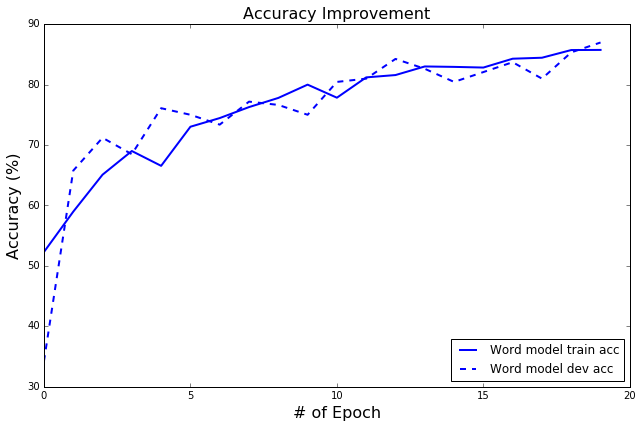

In [617]:
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)

word_train,=plt.plot(history_acc_percentage, linewidth=2,color='blue',linestyle='-',label='Word model train acc')
word_dev,=plt.plot(history_dev_percentage, linewidth=2,color='blue',linestyle='--',label='Word model dev acc')
plt.xlabel('# of Epoch',fontsize=16)
plt.ylabel('Accuracy (%)',fontsize=16)
plt.title('Accuracy Improvement',fontsize=16)
plt.legend(handles=[word_train,word_dev],fontsize=12,loc=4)

plt.show()
fig.savefig('test2png.png', dpi=100)

In [501]:
sum(Y_train)

4914